In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_ts
from warnings import simplefilter
simplefilter("ignore")

In [2]:
df = get_ts(coin="bitcoin",days="max")
df.head(3)

,prices,market_caps,total_volumes
2013-04-28,103.1862,1.144366e+09,0.0
2013-04-29,110.3745,1.224594e+09,0.0
2013-04-30,106.3128,1.179937e+09,0.0


In [3]:
# libs for later (check darts)
#https://towardsdatascience.com/7-libraries-that-help-in-time-series-problems-d59473e48ddd

In [4]:
df.index = pd.to_datetime(df.index)
df.head(3)

,prices,market_caps,total_volumes
2013-04-28,103.1862,1.144366e+09,0.0
2013-04-29,110.3745,1.224594e+09,0.0
2013-04-30,106.3128,1.179937e+09,0.0


In [5]:
df.fillna(df.mean(), inplace=True)
g = df.groupby(pd.Grouper(freq='M')).mean()

In [6]:
g.head(3)

,prices,market_caps,total_volumes
2013-04-30,106.624500,1.182965e+09,0.0
2013-05-31,92.452955,1.032197e+09,0.0
2013-06-30,81.467145,9.197531e+08,0.0


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [8]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [9]:
y = g.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

In [10]:
# Test last 3 years.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 3, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [11]:
# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

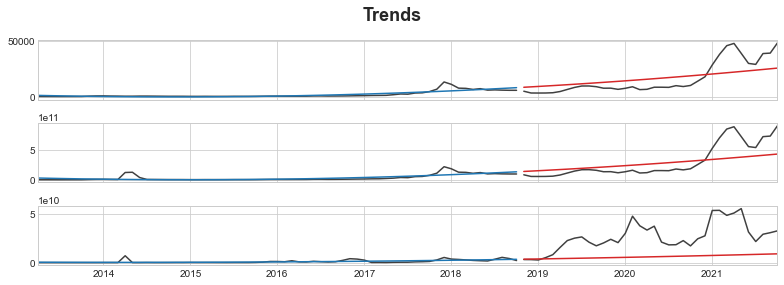

In [12]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [13]:
# Stack rows to predict several series with xgb
X = g.stack()
X = pd.DataFrame(X)
X.columns = ["numeric_values"]
y = X.pop("numeric_values")

In [14]:
X = X.reset_index()
X.index = X.level_0
X.index.name = "month"

X["series_categories"] = X.level_1
X.drop(["level_0", "level_1"], axis=1, inplace=True)
X.head()

,series_categories
month,
2013-04-30,prices
2013-04-30,market_caps
2013-04-30,total_volumes
2013-05-31,prices
2013-05-31,market_caps


In [15]:
# Label encoding for 'categories' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
X.head()

,series_categories
month,
2013-04-30,0
2013-04-30,1
2013-04-30,2
2013-05-31,0
2013-05-31,1


In [16]:
X["Month"] = X.index.month

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [17]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

In [18]:
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

In [19]:
# Train XGBoost on the residuals
xgb = XGBRegressor(n_jobs=1) # reduce to one core. Local machine problem with multiprocessing
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

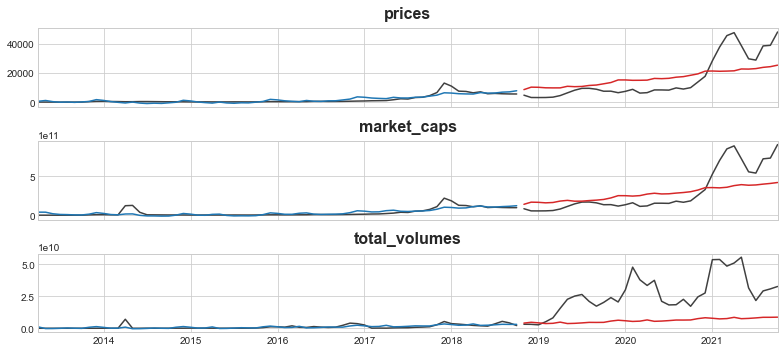

In [27]:
axs = y_train.unstack().plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=list(df.columns),
)
axs = y_test.unstack().plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack().plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack().plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

Well... Comining a linear model and XGBoost didn't really improve performance.

### New Trial

In [30]:
df = get_ts(coin="bitcoin",days="max")
df.index = pd.to_datetime(df.index)
df.index.name = "date"
df.fillna(df.mean(), inplace=True)
df.head(3)

,prices,market_caps,total_volumes
date,,,
2013-04-28,103.1862,1.144366e+09,0.0
2013-04-29,110.3745,1.224594e+09,0.0
2013-04-30,106.3128,1.179937e+09,0.0


In [52]:
class BoostedHybrid:
    
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
    
    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)
        if isinstance(y,pd.Series):
            y = pd.DataFrame(y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()

In [41]:
# Target series
y = df.loc[:, 'prices']

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

# X_2: Features for XGBoost
X_2 = df.drop('prices', axis=1).stack()

In [51]:
isinstance(y,pd.Series)

True

In [42]:
X_2 = pd.DataFrame(X_2)
X_2.columns = ["numeric_values"]
X_2 = X_2.reset_index()
X_2.index = X_2.date
X_2.drop("date", axis=1, inplace=True)
X_2.head(3)

,level_1,numeric_values
date,,
2013-04-28,market_caps,1.144366e+09
2013-04-28,total_volumes,0.000000e+00
2013-04-29,market_caps,1.224594e+09


In [44]:
from sklearn.preprocessing import LabelEncoder
# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing

X_2['series_categories'] = le.fit_transform(X_2['level_1'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [53]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
                categorical type is supplied, DMatrix parameter `enable_categorical` must
                be set to `True`.level_1